In [1]:
# Base libs and modules import

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU, BatchNormalization

In [3]:
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices()[2])

name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4954920064
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7974175319179524696
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1660 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5"



In [4]:
# Distribution of the dataset into training and test samples

In [5]:
(X_train, label_train), (X_test, label_test) = fashion_mnist.load_data()

In [6]:
X_train.shape

(60000, 28, 28)

In [7]:
# Convert the images into 3 channels

In [8]:
X_train = np.dstack([X_train] * 3)
X_test = np.dstack([X_test] * 3)

In [9]:
X_train = X_train.reshape(-1, 28, 28, 3)
X_test = X_test.reshape(-1, 28, 28, 3)
X_train.shape, X_test.shape

((60000, 28, 28, 3), (10000, 28, 28, 3))

In [10]:
# Resize the images into 56x56 px as required by VGG19

In [11]:
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img

In [12]:
X_train = np.asarray([img_to_array(array_to_img(im, scale=False).resize((56,56))) for im in X_train])
X_test = np.asarray([img_to_array(array_to_img(im, scale=False).resize((56,56))) for im in X_test])

In [13]:
# Normalizatoin dataset

In [14]:
X_train = X_train.astype("float32") / 255

X_test = X_test.astype("float32") / 255

In [15]:
# Intro train dataset

In [16]:
label_name = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

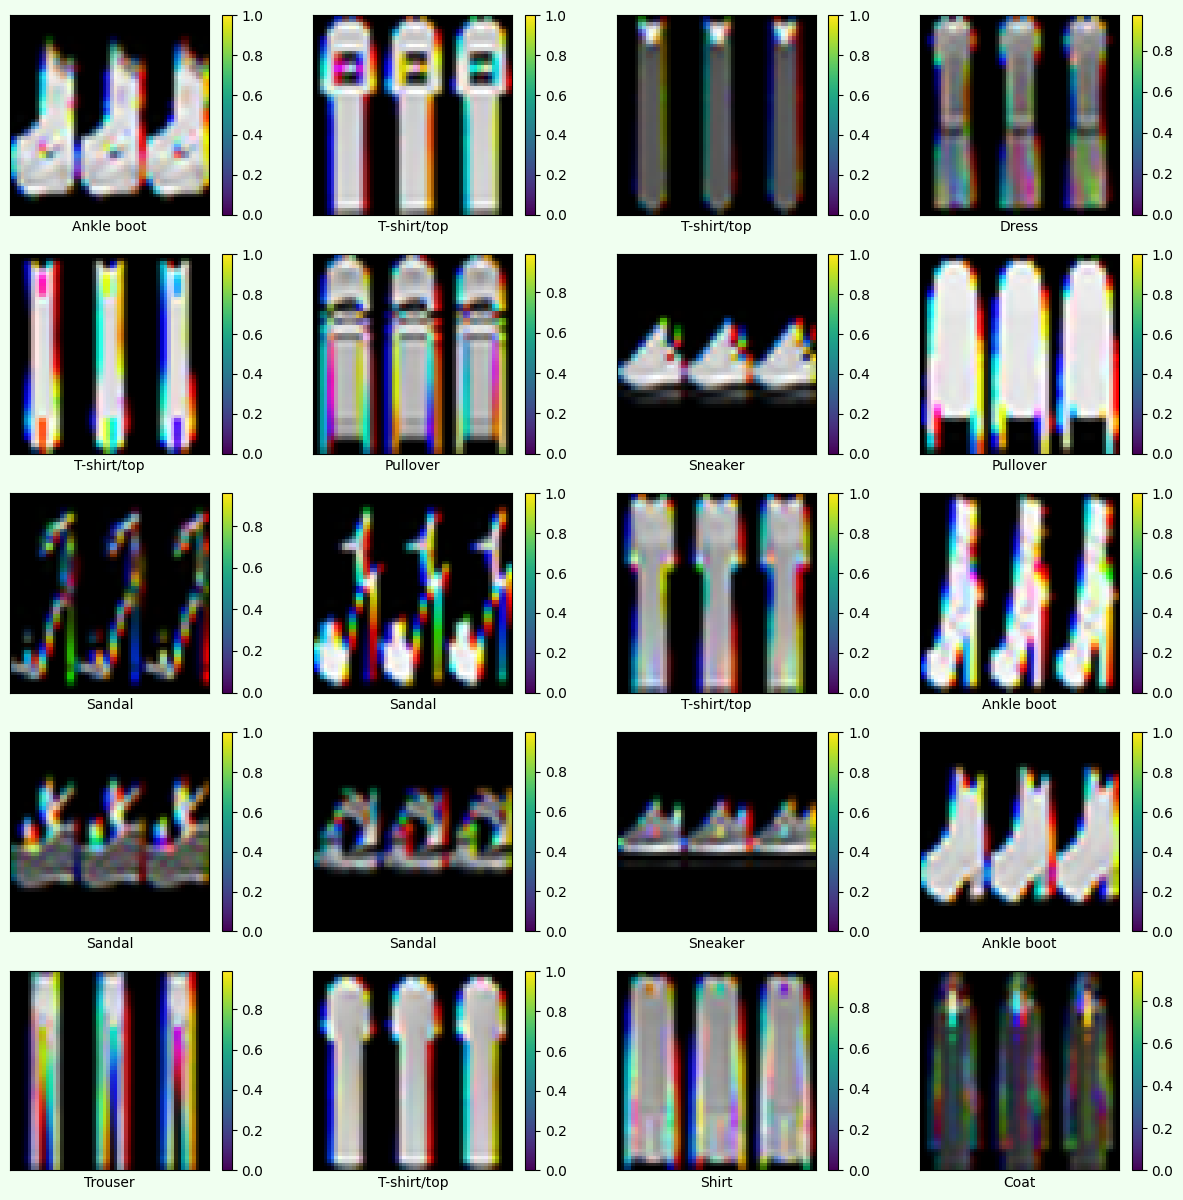

In [17]:
plt.figure(figsize=(15, 15), facecolor='HoneyDew')
for i in range(20):
    plt.subplot(5,4,i+1)
    plt.imshow(X_train[i])
    plt.xticks([])
    plt.yticks([])
    plt.colorbar()
    plt.xlabel(label_name[label_train[i]])

In [18]:
# VGG19 model

In [19]:
from tensorflow.keras.applications.vgg19 import VGG19

In [20]:
vgg19_base = VGG19(weights="imagenet", include_top=False, input_shape=(56, 56, 3))
vgg19_base.trainable = True
set_trainable = False


layer_train_lst = ['block5_conv1', 'block5_conv2','block5_conv3', 'block5_conv4']

for layer in vgg19_base.layers:
    if layer.name in layer_train_lst:
        set_trainable = True
    elif set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [21]:
vgg19_base.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 56, 56, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 56, 56, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 56, 56, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 28, 28, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 28, 28, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 28, 28, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 14, 14, 128)       0     

In [22]:
# Create neural network model with VGG16

In [23]:
model = keras.Sequential([
    vgg19_base,    
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dense(10, activation="softmax", name='out_layer')
])

In [24]:
# Compile model NN

In [25]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 1, 1, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               65664     
_________________________________________________________________
out_layer (Dense)            (None, 10)                1290      
Total params: 20,091,338
Trainable params: 9,506,186
Non-trainable params: 10,585,152
_________________________________________________________________


In [27]:
# Learning model NN

In [28]:
batch_size = 256
epochs = 30
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

In [29]:
history=model.fit(
    X_train,
    label_train,
    validation_split=0.2,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=early_stop
)

Epoch 1/30
188/188 [==============================] - 34s 182ms/step - loss: 0.8333 - accuracy: 0.7182 - val_loss: 0.5063 - val_accuracy: 0.8369
Epoch 2/30
188/188 [==============================] - 28s 151ms/step - loss: 0.4043 - accuracy: 0.8644 - val_loss: 0.3830 - val_accuracy: 0.8723
Epoch 3/30
188/188 [==============================] - 27s 141ms/step - loss: 0.3371 - accuracy: 0.8845 - val_loss: 0.3543 - val_accuracy: 0.8808
Epoch 4/30
188/188 [==============================] - 27s 143ms/step - loss: 0.3024 - accuracy: 0.8952 - val_loss: 0.3505 - val_accuracy: 0.8761
Epoch 5/30
188/188 [==============================] - 26s 141ms/step - loss: 0.2794 - accuracy: 0.9020 - val_loss: 0.3248 - val_accuracy: 0.8909
Epoch 6/30
188/188 [==============================] - 26s 141ms/step - loss: 0.2550 - accuracy: 0.9096 - val_loss: 0.3269 - val_accuracy: 0.8903
Epoch 7/30
188/188 [==============================] - 26s 137ms/step - loss: 0.2374 - accuracy: 0.9167 - val_loss: 0.3543 - val_ac

In [30]:
# Model results

In [31]:
results = model.evaluate(X_test, label_test)
print(f'Model Loss: {round(results[0], 3)} \nModel Accuracy: {round(results[1], 3)}')

313/313 [==============================] - 6s 18ms/step - loss: 0.3423 - accuracy: 0.8867
Model Loss: 0.342 
Model Accuracy: 0.887


In [32]:
# Plot train and validation data

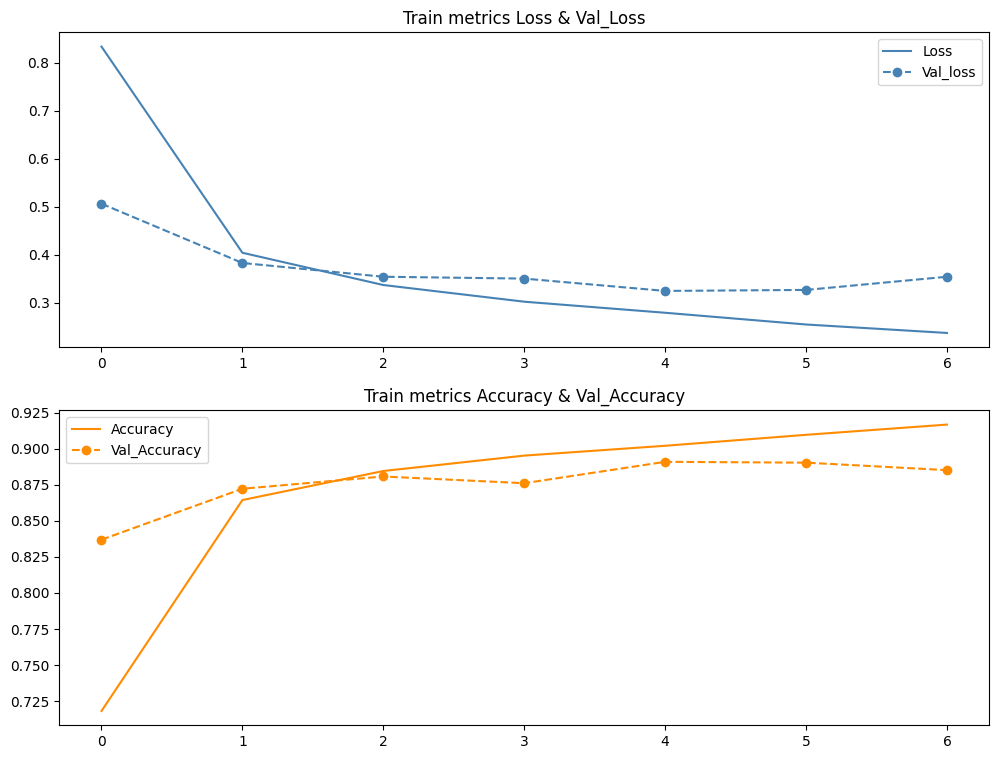

In [33]:
fig, axes = plt.subplots(2, 1, figsize=(12, 9))


axes[0].set_title('Train metrics Loss & Val_Loss')
axes[0].plot(history.history['loss'], label='Loss', color='SteelBlue')
axes[0].plot(history.history['val_loss'], label='Val_loss', marker='o', linestyle='--', color='SteelBlue')
axes[0].legend()

axes[1].set_title('Train metrics Accuracy & Val_Accuracy')
axes[1].plot(history.history['accuracy'], label='Accuracy', color='DarkOrange')
axes[1].plot(history.history['val_accuracy'], label='Val_Accuracy', marker='o', linestyle='--', color='DarkOrange')
axes[1].legend()

plt.show()

In [34]:
# Predict model NN

In [35]:
predict=model.predict(X_test)

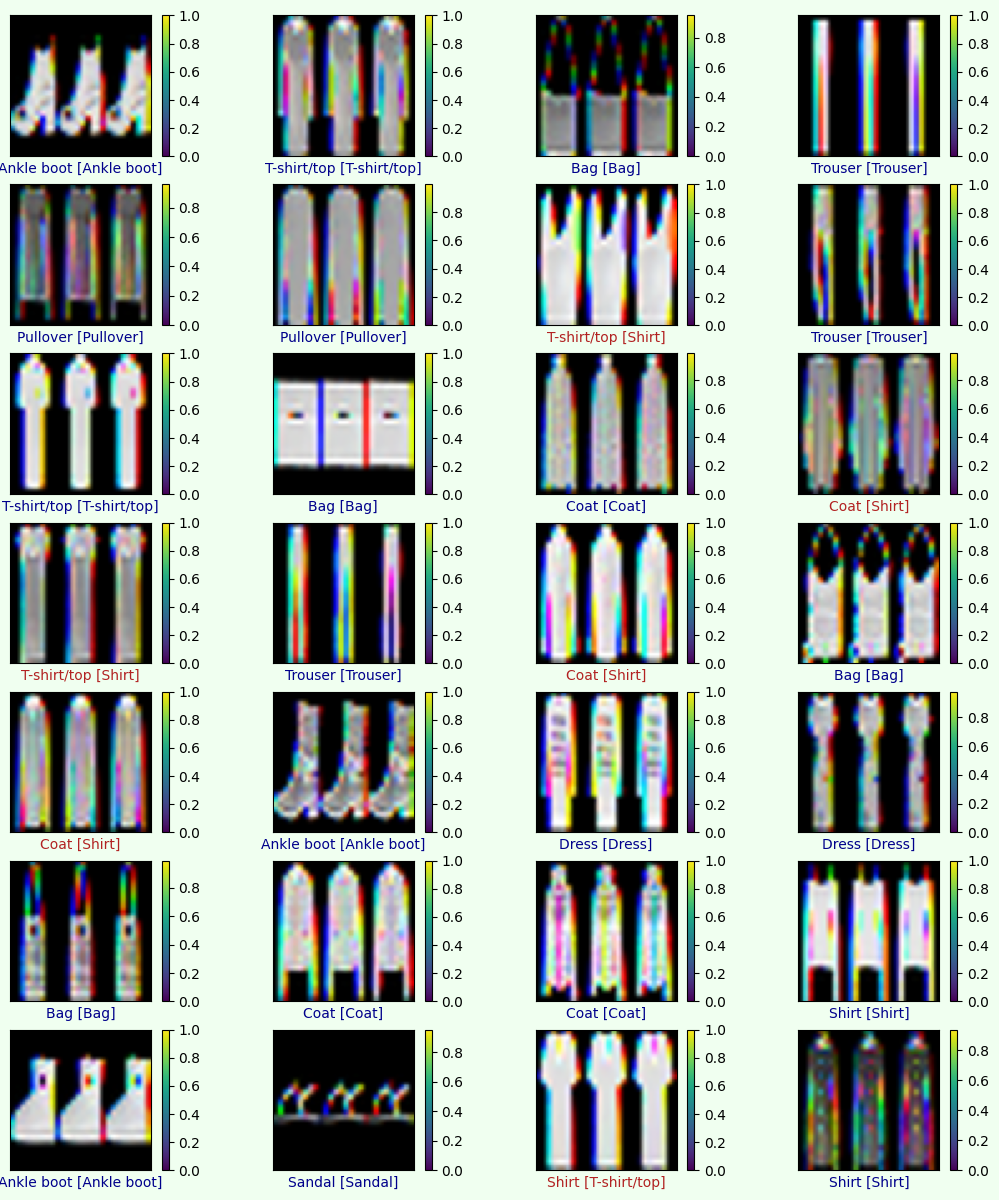

In [36]:
random_indexes = np.random.choice(len(X_test), size=28, replace=False)

plt.figure(figsize=(13, 15), facecolor='HoneyDew')

for i in range(len(random_indexes)):
    
    index = random_indexes[i]
    
    pred_label = label_name[np.argmax(predict[index])]
    true_label = label_name[label_test[index]]
    
    if pred_label == true_label:
        color = "DarkBlue"
    else:
        color = "FireBrick"
    
    plt.subplot(7,4,i+1)
    plt.imshow(X_test[index])
    plt.xticks([])
    plt.yticks([])
    plt.colorbar()
    
    plt.xlabel("{} [{}]".format(true_label, pred_label), color=color)

In [37]:
# Confusion matrix

In [38]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [39]:
pred_label_enc = model.predict(X_test)

pred_label = [np.argmax(i) for i in pred_label_enc]

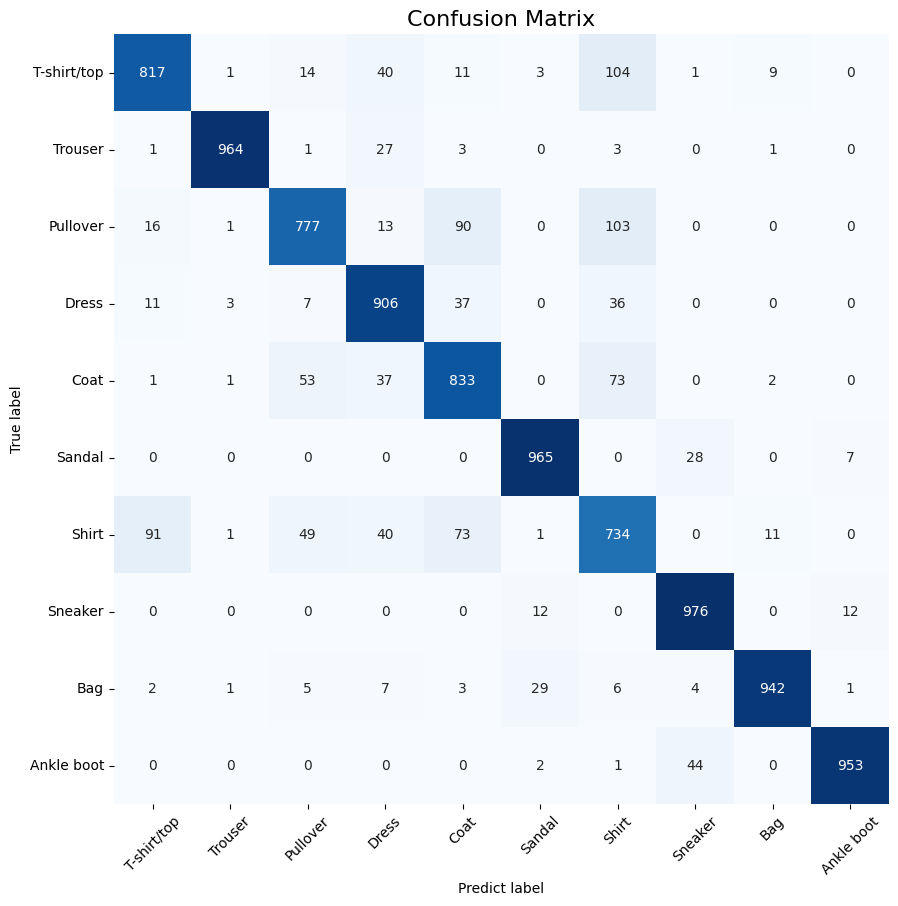

In [40]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(confusion_matrix(label_test, pred_label), annot=True, 
            cbar=False, fmt='1d', cmap='Blues', ax=ax)
ax.set_title('Confusion Matrix', fontsize=16)
ax.set_xlabel('Predict label')
ax.set_ylabel('True label')
ax.set_xticklabels([label for label in label_name], rotation=45)
ax.set_yticklabels(([label for label in label_name]), rotation=0)
plt.show()